In [30]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import requests
import pprint
import difflib

In [ ]:



data = pd.read_csv("vehicles.csv", header = None, skiprows=[0])
column_headers = pd.read_csv("vehicles.csv", nrows=0).columns.tolist()
data.columns = column_headers
data = data.drop(["id", "url", "region_url", "VIN", "size", "image_url", "description", "county", "lat", "long"], axis=1)
#data = data.dropna(subset=['posting_date'])
#data = data.dropna(subset=['condition'])
#drop rows where the manufacturer and model are both null (that should also eleminate rows missing the type as well)
#drop rows where both the title_status and condition are null
data = data.dropna(subset=["title_status", "condition"], how='all')
#drop rows where the posting date is null and the odometer is null
data = data.dropna(subset=["year", "odometer"], how='all')
#drop the rows where the posting date is null

#id, url, region_url, VIN, size, image_url, description, county, lat, long
#year just drop
data = data.dropna(subset=["year"])
#manufacturer fill null values by mapping the model to who is the maker of the model is - Curtis
#model drop the missing model values for now - Curtis
#condition when: - Cole
# title_status clean and odometer less than 500 set to new, 
# title_status clean and odometer less than 5000 set to like new, 
# title_status clean and odometer less than 40000 is excellent, 
# title_status clean and when the odometer is less than 80000 is good,
# title_status clean and when the odometer is less than 120000 is fair,
# title_status salvage then map to salvage
#cylinders drop the column?
#fuel just fill in as gas - Cole
#odometer fill by taking posting_date year - year x 20000 = fill value - Cole
#title_status fill: - Cole
# new, like new excellent, good and fair put as clean
# salvage as salvage
#transmission put as automatic - Curtis
#Option 1: drive taking count for region and then assigning the type based on what is most common in that region
#Option 2: take count for the vehicle type and then assign the type for what is most common for that type
#type map the model to the type - Curtis
#paint_color assign based on the type and what is the most popular for that vehicle type - Curtis

null_rows = data[data[['paint_color']].isnull().all(axis=1)]
# Print all rows where 'column1' and 'column2' are null
#null_rows = data[data["manufacturer"].isna() & data["type"].isna()]

#pprint.pprint(null_rows)
print(len(null_rows))
#print(data.type.value_counts())
#print(data.condition.value_counts())
#print(data.shape[0])
#display(data)


In [31]:
#Curtis cell for data cleaning

#Drop all rows with no manufacturer AND no model
data = data.dropna(subset=["model", "manufacturer"], how="all")

#Find all the unique manufacturers in the Manufacturer column
unique_manufacturers = data["manufacturer"].dropna().unique().tolist()
if "ram" in unique_manufacturers:
    # Remove manufacturer "Ram" as it is to common in other words like Program
    unique_manufacturers.remove("ram")

# Function to fill missing manufacturers based on the model name
def check_manufacturer_in_model_name(data_row):
    if pd.isna(data_row["manufacturer"]) and pd.notna(data_row["model"]):
        for manufacturer in unique_manufacturers:
            if manufacturer.lower() in data_row["model"].lower():  # Case-insensitive matching
                #model_str = str(data_row["model"]) 
                #print(f"Model: {model_str} Closest Manufacturer: {manufacturer.lower()}")
                return manufacturer
    return data_row["manufacturer"]  # Return existing manufacturer if not missing

# Apply the function to update the 'manufacturer' column
data["manufacturer"] = data.apply(check_manufacturer_in_model_name, axis=1)


filtered_data = data[data["manufacturer"].notna() & data["model"].notna()]
model_to_manufacturer = filtered_data.set_index("model")["manufacturer"].to_dict()

def fill_empty_manufacturer_rows(data_row):
    if pd.isna(data_row["manufacturer"]) and pd.notna(data_row["model"]):
        closest_match = difflib.get_close_matches(
            data_row["model"], model_to_manufacturer.keys(), n=1, cutoff=0.7
        )
        if closest_match:
            #model_str = str(data_row["model"])  # Convert model to string
            #print(f"Model: {model_str} Closest Manufacturer: {model_to_manufacturer[closest_match[0]]}")
            return model_to_manufacturer[closest_match[0]]
    return data_row["manufacturer"]

data["manufacturer"] = data.apply(fill_empty_manufacturer_rows, axis=1)

null_rows = data[data[['manufacturer']].isnull().all(axis=1)]
print(f"Number of null manu: {len(null_rows)}")


#Change missing values in transmission column to automatic
data["transmission"] = data["transmission"].fillna(value="automatic")


#paint_color assign based on the type and what is the most popular for that vehicle type - Curtis


In [ ]:
#Curtis cell for data cleaning
# Mapping type to model and replacing all null values with the map/dictionary
filtered_data = data[data["model"].notna() & data["type"].notna()]
model_to_type = filtered_data.set_index("model")["type"].to_dict()

def fill_type(data_row):
    if data_row["model"] in model_to_type and pd.isna(data_row["type"]):
        #model_str = str(data_row["model"])  # Convert model to string
        #print(f"Model: {model_str} Closest type: {model_to_type[data_row['model']]}")
        return model_to_type[data_row["model"]]
    return data_row["type"]

# Apply the function to fill missing manufacturer values
data["type"] = data.apply(fill_type, axis=1)

null_rows = data[data[['type']].isnull().all(axis=1)]
pprint.pprint(null_rows)
print(len(null_rows))

In [48]:
#Cole cell for data cleaning
title_status_mapping = {"new" : "clean", "like new" : "clean", "excellent" : "clean", "good" : "clean", "fair" : "clean", "salvage" : "salvage" }
def format_dates(old_format):
    new_format = old_format.split("-")
    #new_format = datetime.datetime.strptime(old_format,"%Y-%m-%dT%H:%M:%S-%f").date()
    return int(new_format[0])

def fill_conditions(data_row):
# title_status clean and odometer less than 500 set to new, 
    vehicle_condition = data_row["condition"]
    if pd.isna(data_row["condition"]) == False:
        vehicle_condition = data_row["condition"]
    elif (data_row["title_status"] == "clean" or data_row["title_status"] == "lien" or data_row["title_status"] == "missing") and data_row["odometer"] < 500:
        vehicle_condition = "new"
# title_status clean and odometer less than 5000 set to like new, 
    elif (data_row["title_status"] == "clean" or data_row["title_status"] == "lien" or data_row["title_status"] == "missing") and data_row["odometer"] < 5000:
        vehicle_condition = "like new"
# title_status clean and odometer less than 40000 is excellent, 
    elif (data_row["title_status"] == "clean" or data_row["title_status"] == "lien" or data_row["title_status"] == "missing") and data_row["odometer"] < 50000:
        vehicle_condition = "excellent"
# title_status clean and when the odometer is less than 80000 is good,
    elif (data_row["title_status"] == "clean" or data_row["title_status"] == "lien" or data_row["title_status"] == "missing") and data_row["odometer"] < 150000:
        vehicle_condition = "good"
# title_status clean and when the odometer is less than 120000 is fair,
    elif (data_row["title_status"] == "clean" or data_row["title_status"] == "lien" or data_row["title_status"] == "missing") and data_row["odometer"] <= 220000:
        vehicle_condition = "fair"
# title_status salvage then map to salvage
    else:
        vehicle_condition = "salvage"
    return vehicle_condition

data["fuel"] = data["fuel"].fillna(value="gas")
data["title_status"] = data["title_status"].fillna(value=data["condition"].map(title_status_mapping))
data["posting_date"] = data["posting_date"].apply(format_dates)
data["odometer"] = data["odometer"].fillna(value=(data["posting_date"] - data["year"]) * 20000)
data["condition"] = data.apply(fill_conditions, axis=1)
#print(data.isna().sum())
# null_rows = data[data[['condition']].isnull().all(axis=1)]
# print(null_rows.title_status.value_counts())
# print(data.condition.value_counts())
# print(null_rows.odometer.value_counts())

In [37]:
from sklearn.model_selection import train_test_split

y = data["price"]
y.columns = ["price"]
X = data.drop("price", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

<Figure size 432x288 with 0 Axes>

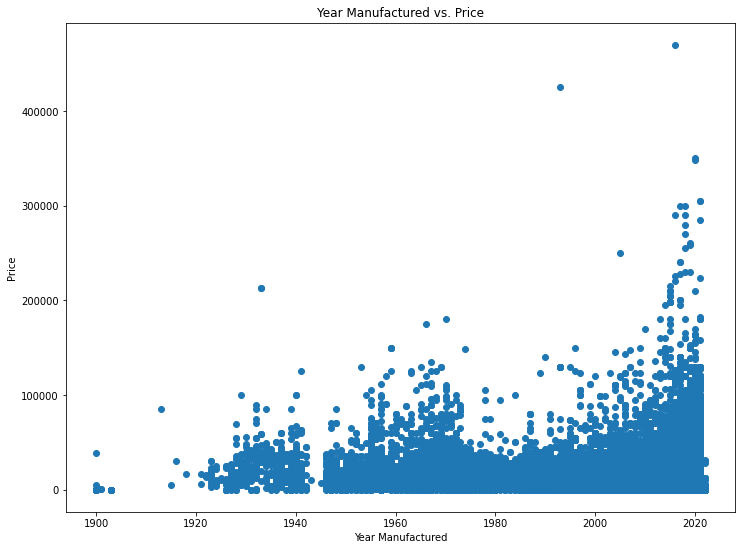

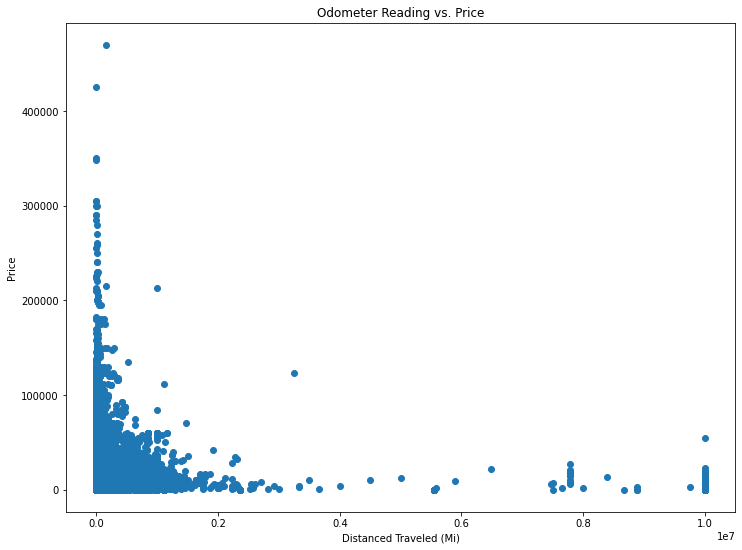

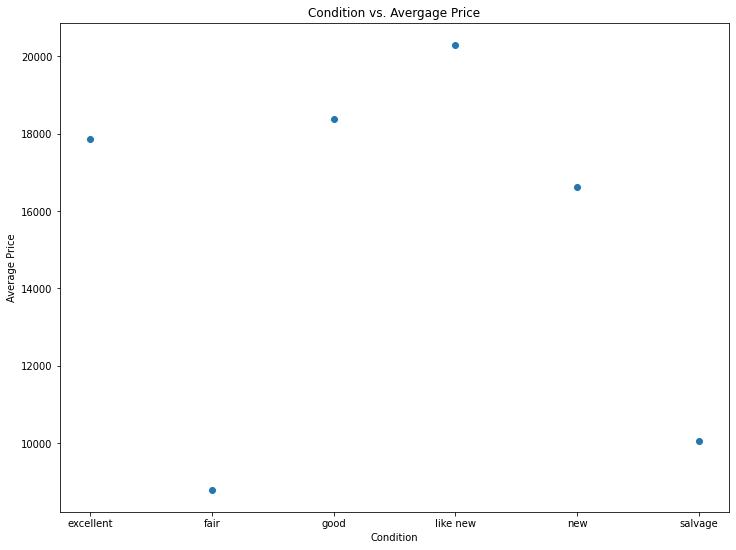

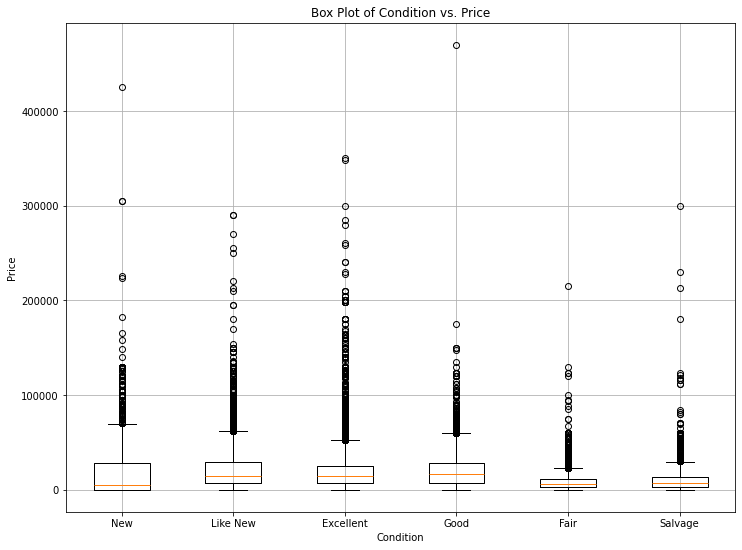

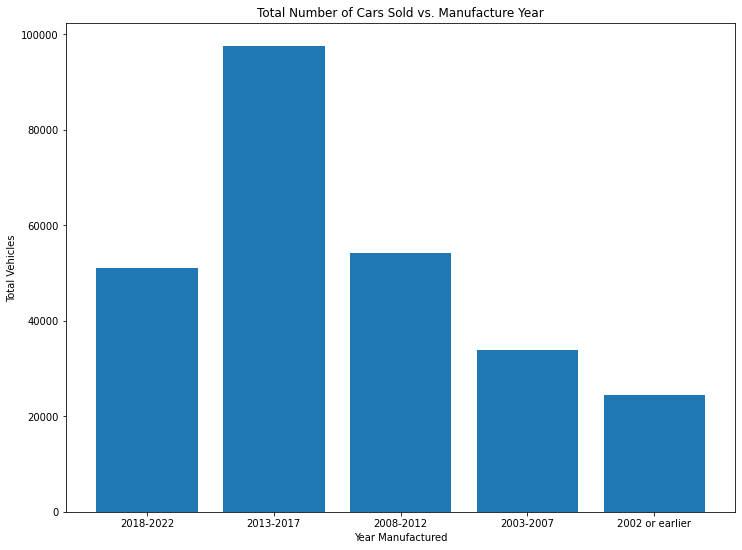

In [4]:
#code for analysis
data = data[data["price"] < 500000]
plt.figure(1)
plt.figure(figsize=(12, 9))
plt.scatter(data["year"], data["price"])
plt.title("Year Manufactured vs. Price")
plt.ylabel("Price")
plt.xlabel("Year Manufactured")

plt.figure(2)
plt.figure(figsize=(12, 9))
plt.scatter(data["odometer"], data["price"])
plt.title("Odometer Reading vs. Price")
plt.ylabel("Price")
plt.xlabel("Distanced Traveled (Mi)")

plt.figure(3)
plt.figure(figsize=(12, 9))
plt.scatter(list(data.groupby("condition")["price"].groups.keys()), data.groupby("condition")["price"].mean().tolist())
plt.title("Condition vs. Avergage Price")
plt.ylabel("Average Price")
plt.xlabel("Condition")

plt.figure(4)
plt.figure(figsize=(12, 9))
new_condition = data.loc[data["condition"] == "new", ['price']]
like_new_condition = data.loc[data["condition"] == "like new", ['price']]
excellent_condition = data.loc[data["condition"] == "excellent", ['price']]
good_condition = data.loc[data["condition"] == "good", ['price']]
fair_condition = data.loc[data["condition"] == "fair", ['price']]
salvage_condition = data.loc[data["condition"] == "salvage", ['price']]
plt.boxplot([new_condition["price"], like_new_condition["price"], excellent_condition["price"], good_condition["price"], fair_condition["price"], salvage_condition["price"]])
plt.xticks([1, 2, 3, 4, 5, 6],["New", "Like New", "Excellent", "Good", "Fair", "Salvage"])

plt.title("Box Plot of Condition vs. Price")
plt.ylabel("Price")
plt.xlabel("Condition")
plt.grid(True)


plt.figure(5)
plt.figure(figsize=(12, 9))
x = np.array(["2018-2022", "2013-2017", "2008-2012", "2003-2007", "2002 or earlier"])
y = np.array([
    data[data["year"] > 2017]["year"].shape[0], 
    data[(data["year"] <= 2017) & (data["year"] > 2012)]["year"].shape[0], 
    data[(data["year"] <= 2012) & (data["year"] > 2007)]["year"].shape[0], 
    data[(data["year"] <= 2007) & (data["year"] > 2002)]["year"].shape[0],
    data[data["year"] <= 2002]["year"].shape[0]
])

plt.title("Total Number of Cars Sold vs. Manufacture Year")
plt.ylabel("Total Vehicles")
plt.xlabel("Year Manufactured")
plt.bar(x,y)

# Display the plot
plt.show()

In [39]:
#code for model

In [40]:
#code for validation